## Machine learning

In [54]:
# pip install -U spacy - in prompt
# python -m spacy download en - in prompt
# python -m spacy download en_core_web_sm
# conda install -c conda-forge spacy-model-en_core_web_sm

import random
import pandas as pd
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

df = pd.read_excel("C:/Users/Ejer/Documents/GitHub/SDS2019-Group37/Assignments/List_Songs-HIPPOP.xlsx")
dummy=pd.get_dummies(df["Genre"])
df = pd.concat([df, dummy], axis=1)
df.drop_duplicates()

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
# spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [55]:
from sklearn.base import TransformerMixin

# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [56]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)


In [58]:
from sklearn.model_selection import train_test_split

X = df['Lyrics'] # the features we want to analyze
ylabels = df['Hip Hop'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV

classifier = LogisticRegressionCV(cv=6)

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf_vector), # can use the bow vector and change the range
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('cleaner', <__main__.predictors object at 0x000001A18BF8E5F8>), ('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
    ...    random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0))])

In [60]:
from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))

Logistic Regression Accuracy: 0.8
Logistic Regression Precision: 0.8518518518518519
Logistic Regression Recall: 0.71875


# Sentiment analysis

### Applying the NRC lexicon from Stanford

In [61]:
import pandas as pd
import numpy as np
filepath = "http://web.stanford.edu/class/cs124/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
lexicon_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=45, sep='\t')
lexicon_df.head(30)

,word,emotion,association
0,aback,anger,0
1,aback,anticipation,0
2,aback,disgust,0
3,aback,fear,0
4,aback,joy,0
5,aback,negative,0
6,aback,positive,0
7,aback,sadness,0
8,aback,surprise,0
9,aback,trust,0


## Showing the lexicon

In [62]:
lexicon_df["emotion"].drop_duplicates()

0           anger
1    anticipation
2         disgust
3            fear
4             joy
5        negative
6        positive
7         sadness
8        surprise
9           trust
Name: emotion, dtype: object

In [63]:
lexicon_word = lexicon_df.pivot(columns='emotion', values='association', index='word') #.reset_index()
lexicon_word = lexicon_word[1:]
lexicon_word.head()

emotion,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
word,,,,,,,,,,
aback,0,0,0,0,0,0,0,0,0,0
abacus,0,0,0,0,0,0,0,0,0,1
abandon,0,0,0,1,0,1,0,1,0,0
abandoned,1,0,0,1,0,1,0,1,0,0
abandonment,1,0,0,1,0,1,0,1,1,0


#### Observation: "Anaconda" is associated with "disgust", "fear" and "negative". 
In the song "Anaconda" by Nicki Minaj it means her bum. It is not negative in that song and the lexicon is therefore wrong in regards to that song.

In [64]:
df = pd.read_excel("C:/Users/Ejer/Documents/GitHub/SDS2019-Group37/Assignments/List_Songs-HIPPOP.xlsx")
dummy=pd.get_dummies(df["Genre"])
df = pd.concat([df, dummy], axis=1)

def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

#applying tokenizer on lyrics in Dataframe
df["Lyrics"] = df["Lyrics"].apply(spacy_tokenizer)

In [65]:
feeling_set = {k: set(lexicon_word[lexicon_word[k] == 1].index) for k in lexicon_word.columns}

In [66]:
feeling_set.keys()

dict_keys(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust'])

In [67]:
def feeling_counter(l):
    res = {
        "anger": 0,
        "anticipation": 0,
        'disgust': 0,
        'fear': 0,
        'joy': 0, 
        'negative': 0, 
        'positive': 0, 
        'sadness': 0, 
        'surprise': 0, 
        'trust': 0
     }
    for word in l:
        for key in res.keys():
            if word in feeling_set[key]:
                res[key] += 1
    return res

In [68]:
# Testing
feeling_counter(["disgust", "serious", "what", "gross"])

{'anger': 1,
 'anticipation': 0,
 'disgust': 2,
 'fear': 1,
 'joy': 0,
 'negative': 2,
 'positive': 0,
 'sadness': 1,
 'surprise': 0,
 'trust': 0}

In [69]:
# Creating one dataframe
df2 = pd.concat([df, pd.DataFrame(df["Lyrics"].apply(feeling_counter).tolist())], axis=1)
df2

,Unnamed: 0,Lyrics,Title,Year,Genre,Hip Hop,Pop,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,1,"[uh, uh, uh, bring, attention, dirty, watch, t...",#1,2002,Hip Hop,1,0,10,11,8,7,8,31,24,10,10,11
1,2,"[chorus, 2x):(mannie, fresh, niggas, buck, buc...",#1,2002,Hip Hop,1,0,16,4,11,14,9,34,21,7,9,7
2,3,"[rich, nice, want, understand, mackin, big, bu...",#1 Player,1995,Hip Hop,1,0,29,19,11,5,32,48,47,8,6,20
3,4,"[nigga, stunt, come, f*ckin, car, nigga, belie...",#1 Stunna,2000,Hip Hop,1,0,38,7,30,28,11,47,15,22,3,4
4,5,"[girl, birthday, birthday, tonight, tonight, g...",#BDAY,NONE,Hip Hop,1,0,11,30,10,5,35,17,42,6,28,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,428,"[sittin, morning, sun, sittin, come, watchin, ...",(Sittinâ€™ On) The Dock of the Bay,2010,Pop,0,1,0,9,0,6,3,2,3,2,4,3
428,429,"[high, build, barrier, tall, far, right, away,...",(Something Inside) So Strong,2001,Pop,0,1,4,3,1,1,7,15,9,2,1,3
429,430,"[know, grant, thing, way, want, oh, treetop, s...",(Still A) Weirdo,2010,Pop,0,1,0,5,0,10,9,10,14,0,0,7
430,431,"[know, bed, feel, warm, sleeping, know, dream,...",Stronger (What Doesn't Kill You),2011,Pop,0,1,7,4,8,21,4,24,4,23,8,2


# Investigating the data

In [70]:
df3=df2.drop(columns='Unnamed: 0')
df3=df3.drop(columns='Lyrics')
df3=df3.drop(columns='Title')
#df3=df3.drop(columns='Year')
df3=df3.drop(columns='Hip Hop')
df3=df3.drop(columns='Pop')

In [71]:
df4=df3.groupby("Genre").mean()
df4

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
Genre,,,,,,,,,,
Hip Hop,11.879630,9.754630,7.740741,10.578704,10.356481,20.782407,19.250000,9.115741,6.583333,9.134259
Pop,2.236111,4.685185,1.412037,2.824074,8.777778,5.083333,11.726852,2.981481,3.254630,4.564815


In [72]:
df6=df3.replace(to_replace= [1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939], value="1930")
df6=df6.replace(to_replace= [1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949], value="1940")
df6=df6.replace(to_replace= [1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959], value="1950")
df6=df6.replace(to_replace= [1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969], value="1960")
df6=df6.replace(to_replace= [1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979], value="1970")
df6=df6.replace(to_replace= [1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989], value="1980")
df6=df6.replace(to_replace= [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999], value="1990")
df6=df6.replace(to_replace= [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009], value="2000")
df6=df6.replace(to_replace= [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019], value="2010")

df7=df6.groupby(["Genre", "Year"]).mean()
df7

anger  anticipation    disgust       fear        joy  \
Genre   Year                                                             
Hip Hop 1980  17.600000     11.400000  10.000000  18.600000  14.400000   
        1990  16.341463     11.341463   8.121951  14.439024  12.536585   
        2000  14.152778     11.902778   9.750000  12.055556  12.416667   
        2010  11.725490     10.588235   8.980392  11.470588  11.803922   
        NONE   4.063830      4.000000   2.744681   3.127660   3.297872   
Pop     1950   3.000000      6.000000   2.000000   5.000000   6.000000   
        1960   2.142857      4.428571   2.428571   3.142857  10.142857   
        1970   2.923077      6.000000   2.615385   3.538462  11.000000   
        1980   2.954545      6.136364   1.227273   3.727273   9.136364   
        1990   2.836735      6.020408   1.632653   3.551020  10.244898   
        2000   2.617021      4.936170   1.574468   2.468085  12.617021   
        2010   2.862069      7.206897   2.379310   4.793103  11.482759   
        NONE   0.354167      0.541667   0.041667   0.541667   0.979167   

               negative   positive    sadness  surprise      trust  
Genre   Year                                                        
Hip Hop 1980  32.800000  28.800000   8.800000  6.400000  21.800000  
        1990  29.073171  24.097561  12.000000  7.926829  10.756098  
        2000  24.569444  24.541667  11.194444  8.125000  10.125000  
        2010  21.411765  19.921569   9.980392  7.411765  11.039216  
        NONE   5.787234   5.170213   2.510638  2.170213   2.787234  
Pop     1950   7.000000   7.000000   2.000000  8.000000   2.000000  
        1960   6.000000  12.285714   4.428571  3.571429   5.285714  
        1970   7.846154  14.000000   5.076923  4.000000   5.153846  
        1980   6.045455  14.227273   3.454545  3.045455   6.409091  
        1990   5.367347  14.061224   3.122449  4.163265   5.408163  
        2000   5.340426  15.957447   3.553191  3.361702   5.085106  
        2010   9.344828  15.620690   4.931034  5.655172   6.827586  
        NONE   0.604167   1.104167   0.125000  0.520833   0.770833

# Creating the visuals

In [73]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns 

%matplotlib inline 

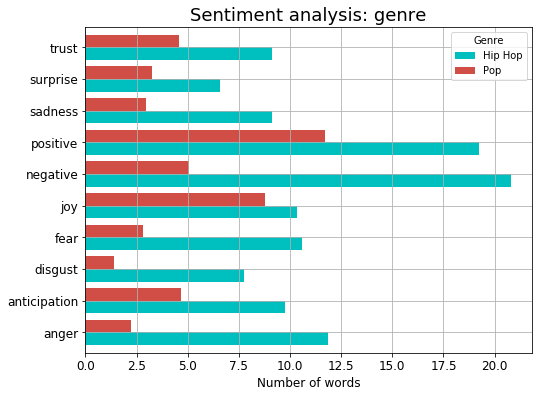

In [74]:
df4=df3.groupby("Genre").mean()
df5=df4.transpose()

df_sent1 = df5.plot(kind="barh", fontsize=12, grid=True, color=["c", "#D14E46"], width=0.8, figsize=(8, 6))
df_sent1.set_title('Sentiment analysis: genre', fontsize=18)
df_sent1.set_xlabel('Number of words', fontsize=12)
df_sent1.figure.savefig('Sentiment_analysis_genre')
# https://htmlcolorcodes.com/    <-- Hjemmeside til farver

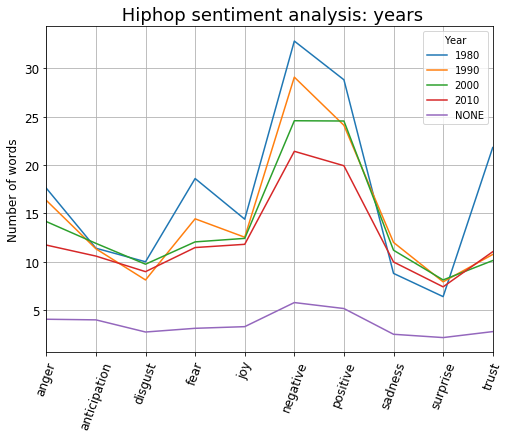

In [75]:
df8=df6.loc[df6["Genre"]=="Hip Hop"]
df9=df8.groupby(["Year"]).mean()
df_year=df9.transpose()

df_sent2 = df_year.plot(fontsize=12, grid=True, figsize=(8, 6))
df_sent2.set_title(' Hiphop sentiment analysis: years', fontsize=18)
df_sent2.set_ylabel('Number of words', fontsize=12)
df_sent2.figure.savefig('Sentiment_analysis_years_hiphop')
df_sent2.tick_params(axis='x', labelrotation=70)

# https://htmlcolorcodes.com/    <-- Hjemmeside til farver

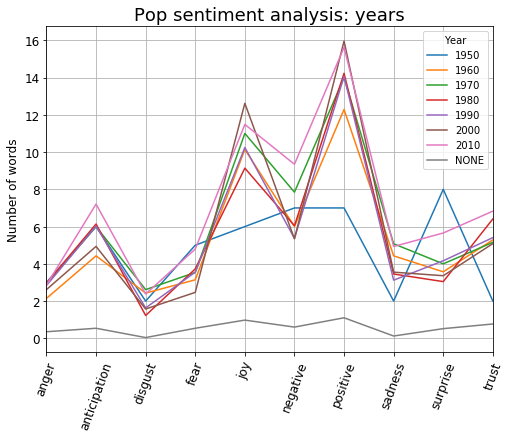

In [76]:
df11=df6.loc[df6["Genre"]=="Pop"]
df12=df11.groupby(["Year"]).mean()
df_year1=df12.transpose()

df_sent3 = df_year1.plot(fontsize=12, grid=True, figsize=(8, 6))
df_sent3.set_title('Pop sentiment analysis: years', fontsize=18)
df_sent3.set_ylabel('Number of words', fontsize=12)
df_sent3.figure.savefig('Sentiment_analysis_years_pop')
df_sent3.tick_params(axis='x', labelrotation=70)

# https://htmlcolorcodes.com/    <-- Hjemmeside til farver

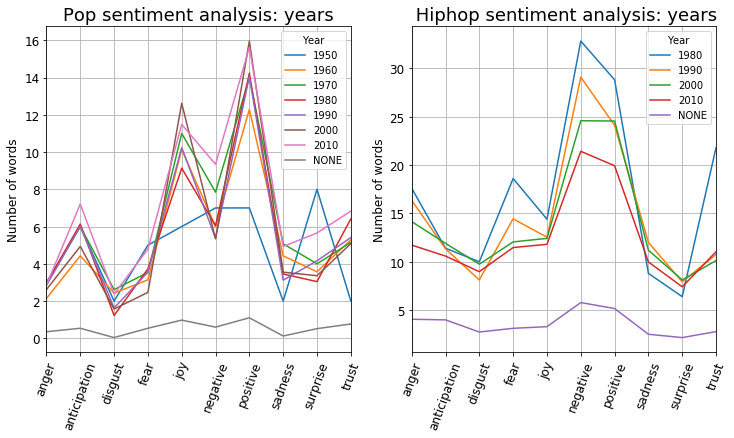

In [77]:
fig, axes = plt.subplots(1,2)

a = df_year1.plot(fontsize=12, grid=True, figsize=(12, 6), ax=axes[0])
a.set_title('Pop sentiment analysis: years', fontsize=18)
a.set_ylabel('Number of words', fontsize=12)
a.tick_params(axis='x', labelrotation=70)

b = df_year.plot(fontsize=12, grid=True, figsize=(12, 6), ax=axes[1])
b.set_title(' Hiphop sentiment analysis: years', fontsize=18)
b.set_ylabel('Number of words', fontsize=12)
b.tick_params(axis='x', labelrotation=70)

In [273]:
# df2.groupby("Hip Hop")
# df_hiphop=df3[0:216]
# df_pop=df3[217:]

# Applying the Spacy

In [43]:
# Download the Spacy first by typing this into your Prompt: "pip install spacy" and "python -m spacy download en_core_web_sm"
import spacy

nlp = spacy.load('en_core_web_sm')
doc = nlp('Havana is dancing uh na')

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_)

Havana Havana PROPN NNP nsubj Xxxxx
is be VERB VBZ aux xx
dancing dance VERB VBG ROOT xxxx
uh uh INTJ UH intj xx
na na ADP IN prep xx


Havana is dancing uh na

#### Observation: This one can find the nouns, verbs ect. in a song. We can then analyzise which "word class" they use the most.  